# Problem 2:
1) Prepare a classification model using SVM for salary data 

## 1. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

In [2]:
%matplotlib notebook

## 2. Load data

In [3]:
salary_df = pd.read_csv('SalaryData_Train(1).csv')

In [4]:
salary_df.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 3. EDA
### 3.1 Data understanding 

In [5]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            30161 non-null  int64 
 1   workclass      30161 non-null  object
 2   education      30161 non-null  object
 3   educationno    30161 non-null  int64 
 4   maritalstatus  30161 non-null  object
 5   occupation     30161 non-null  object
 6   relationship   30161 non-null  object
 7   race           30161 non-null  object
 8   sex            30161 non-null  object
 9   capitalgain    30161 non-null  int64 
 10  capitalloss    30161 non-null  int64 
 11  hoursperweek   30161 non-null  int64 
 12  native         30161 non-null  object
 13  Salary         30161 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


In [6]:
salary_df['education'].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
       ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' Preschool',
       ' 12th', ' 1st-4th'], dtype=object)

In [7]:
len(salary_df['education'].unique())

16

In [8]:
salary_df['educationno'].unique() # label/ ordinal encoding of 'education' column - therefore, remove.

array([13,  9,  7, 14,  5, 10, 12,  4, 16, 11, 15,  3,  6,  1,  8,  2],
      dtype=int64)

In [9]:
salary_df['native'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
       ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
       ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
       ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
       ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
       ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
       ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
       ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
       ' Hungary'], dtype=object)

In [10]:
len(salary_df['native'].unique())

40

### 3.2 Separating data into features and target.

In [11]:
# Extracting column names and sorting them to appropriate categories.
def column_segregator(df, y_name=None):
    """ Returns  three lists of column headers for feature columns, 
    numeric columns and categorical columns
    Input
    ------
    df: Dataframe
    y_name: default None. Name(str) of target column if available
    
    Output
    ------
    features, numeric_cols, cat_cols"""   
    
    cols = df.columns # List of all columns in the input dataframe.
    numeric_cols = [col for col in cols if (df[col].dtypes != 'object') and col != y_name]
    cat_cols = [col for col in cols if (df[col].dtypes == 'object') and col != y_name]
    features = [col for col in cols if col != y_name]
    
    return features, numeric_cols, cat_cols 

In [12]:
def Xy_split(df, y_name=None, y_col=True):
    """Splits the input dataframe into features and target
    input
    -----
    df: Input dataframe
    y_name: default None. Name(str) of target column if available
    y_col: 'True' if y column is present in input dataframe, else 'False'.
    
    output
    ------
    X (features) , y (target) if y colum is present else only X"""
    
    target = y_name
    feature_col,_,_ = column_segregator(df, target)
    if y_col == True:
        # separating features and target.
        X = df.loc[:, feature_col]
        y = df.loc[:, target]
        return X,y
    else:
        X = df.loc[:, feature_col]
        return X

In [13]:
# Column segregation.
features, numeric_cols, cat_cols = column_segregator(salary_df, y_name='Salary')

In [14]:
features

['age',
 'workclass',
 'education',
 'educationno',
 'maritalstatus',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capitalgain',
 'capitalloss',
 'hoursperweek',
 'native']

In [15]:
numeric_cols

['age', 'educationno', 'capitalgain', 'capitalloss', 'hoursperweek']

In [16]:
cat_cols

['workclass',
 'education',
 'maritalstatus',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native']

In [17]:
# Required features and numeric columns
req_features = [col for col in features if( col!='educationno')]
numcols = [col for col in numeric_cols if (col !='educationno')]
cat_cols_oe = [col for col in cat_cols if(col!='native')] # 'native' col will be frequency encoded.

In [18]:
X, y = Xy_split(salary_df, y_name='Salary', y_col=True)

### 3.3 Visualizations

#### 3.3.1 Feature distribution - Numeric features:

<IPython.core.display.Javascript object>


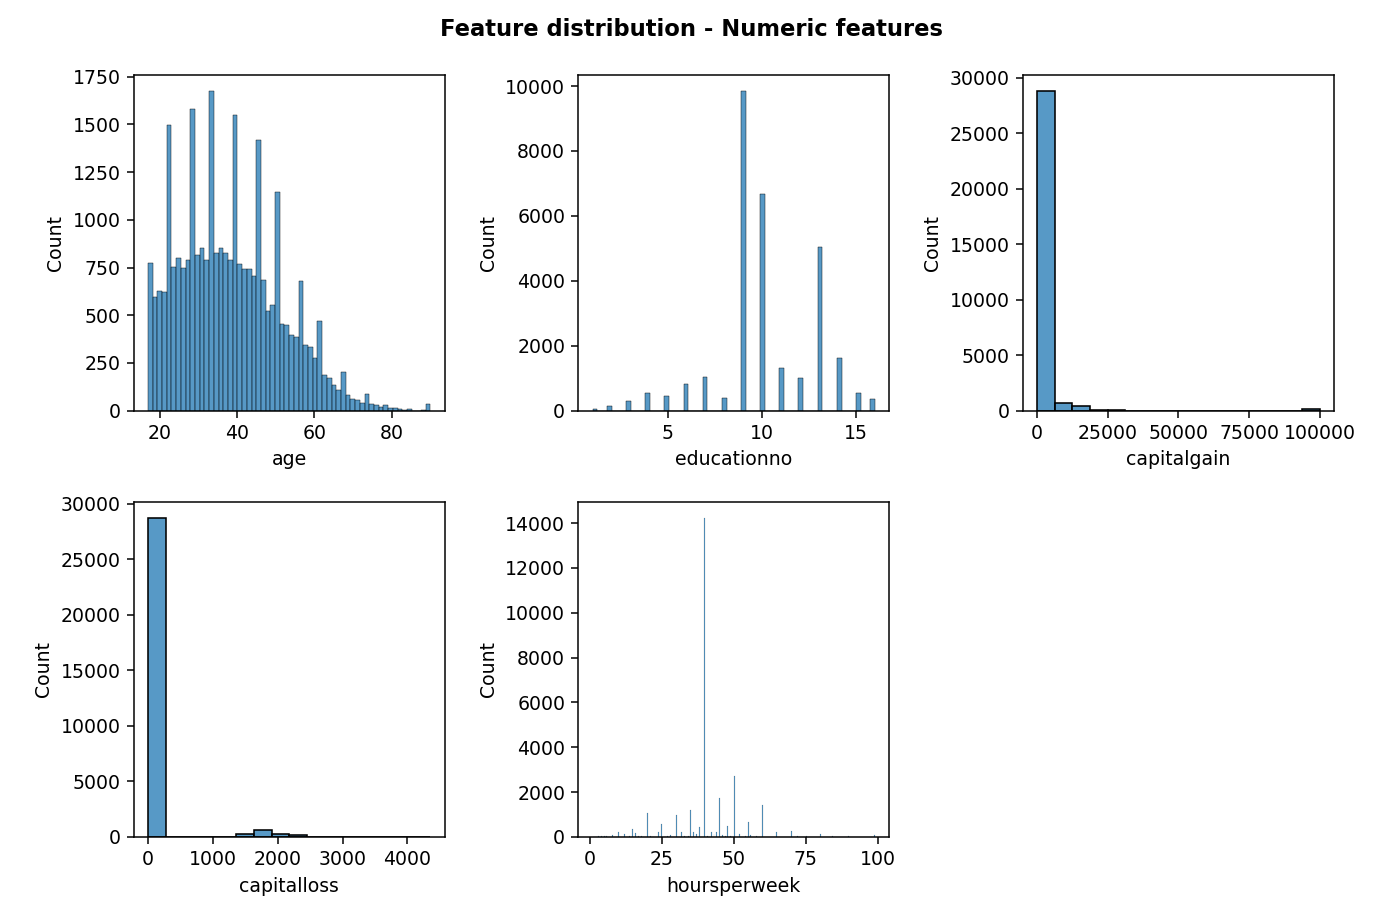

In [19]:
fig, axes = plt.subplots(2,3, figsize=(9,6))
fig.delaxes(axes[1,2])
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < 5:
        sns.histplot(data=X, x=X[numeric_cols[idx]], ax=ax)
    
fig.suptitle('Feature distribution - Numeric features', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

#### 3.3.2 Feature distribution - categorical features

<IPython.core.display.Javascript object>


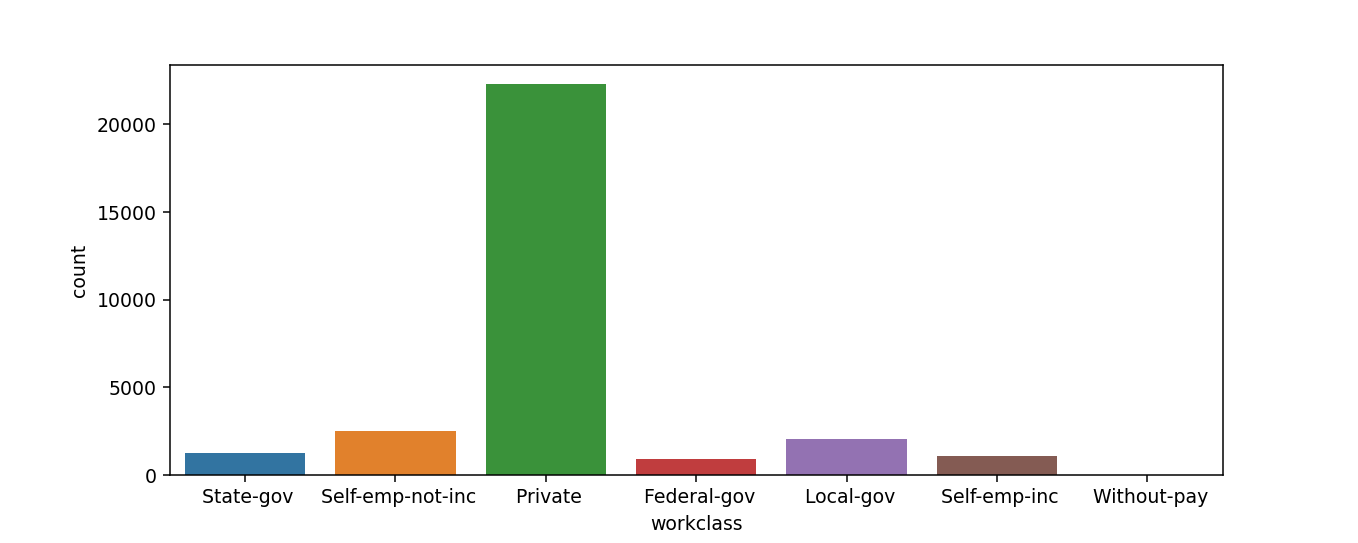

In [20]:
fig, ax = plt.subplots(figsize=(10,4))
sns.countplot(data=X, x=X[cat_cols[0]], ax=ax) 
plt.show()

<IPython.core.display.Javascript object>


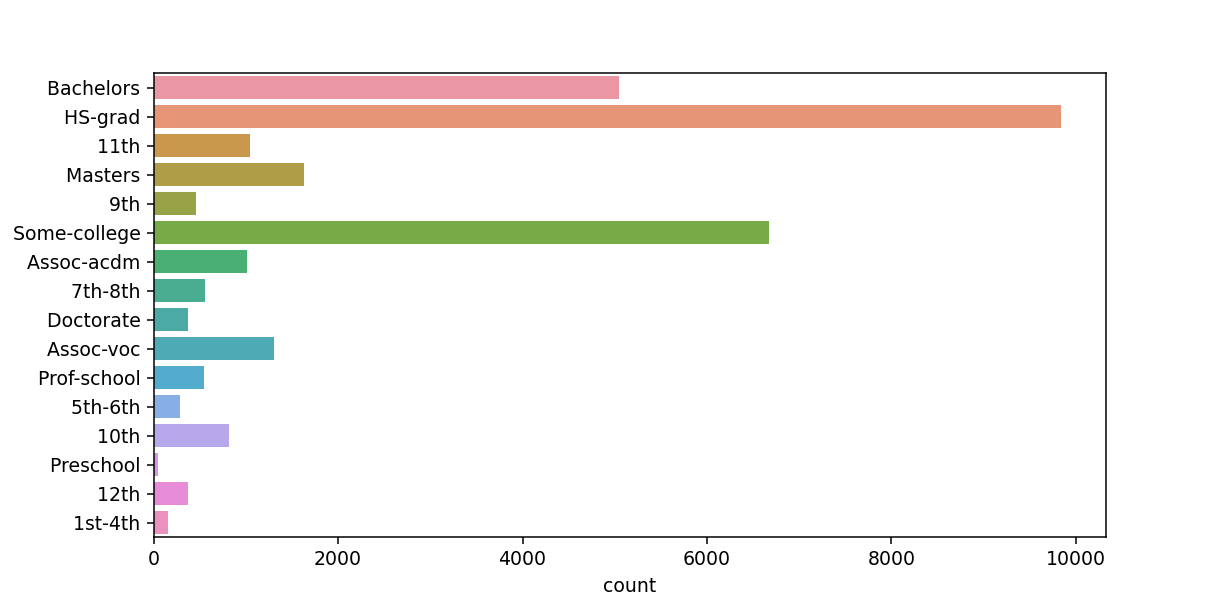

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data=X, y=X[cat_cols[1]], ax=ax) 
plt.show()

<IPython.core.display.Javascript object>


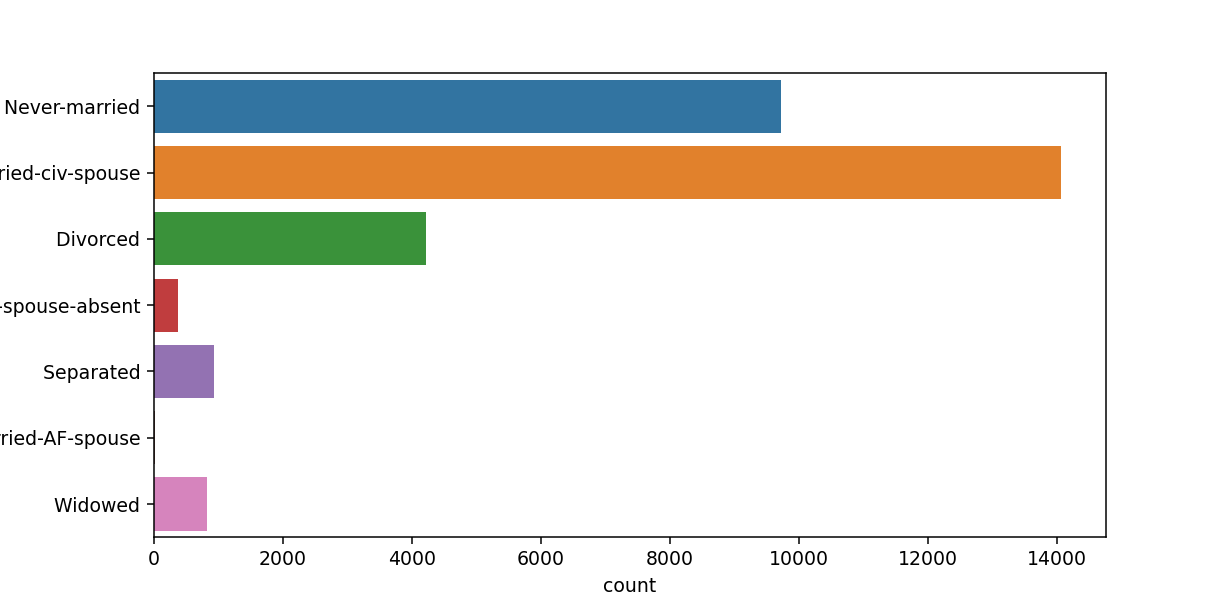

In [22]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data=X, y=X[cat_cols[2]], ax=ax) 
plt.show()

<IPython.core.display.Javascript object>


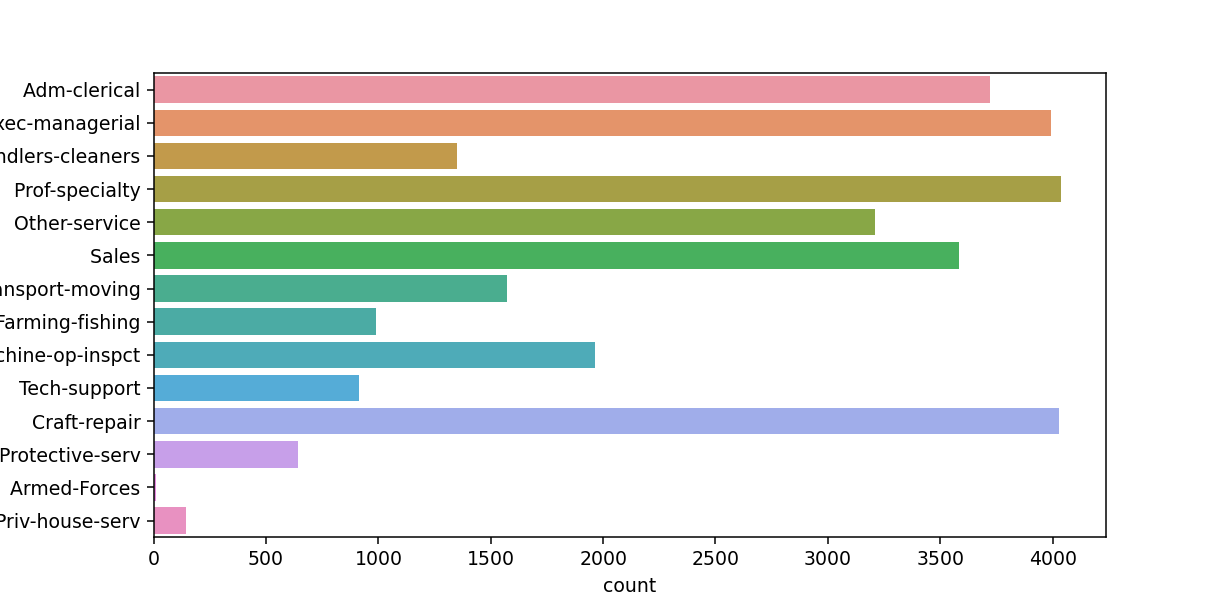

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data=X, y=X[cat_cols[3]], ax=ax) 
plt.show()

<IPython.core.display.Javascript object>


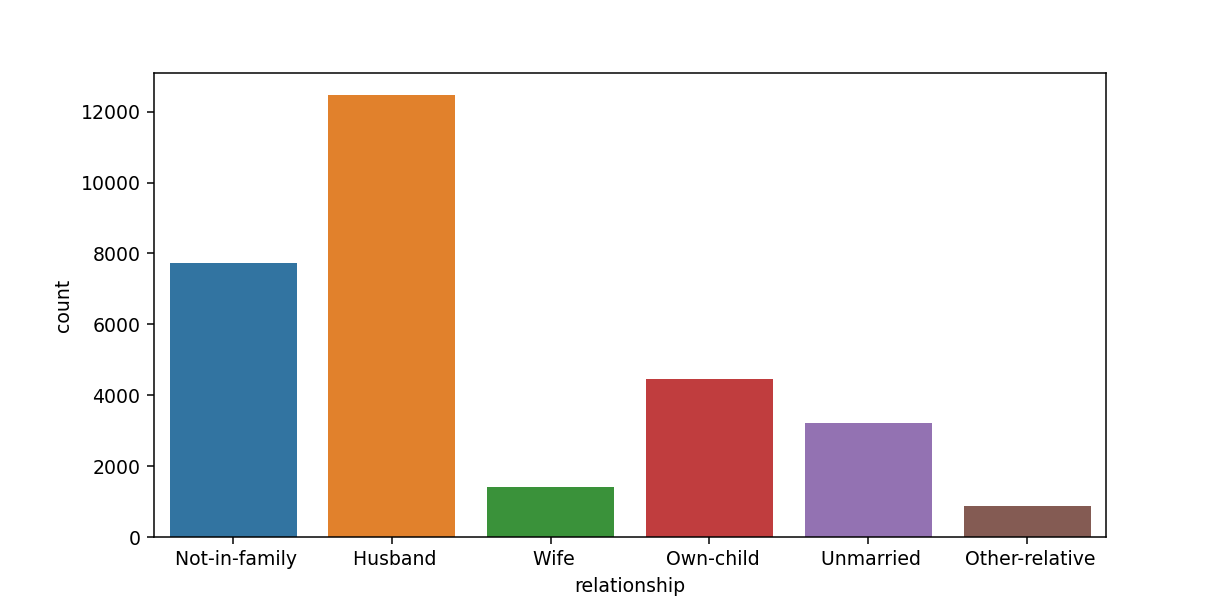

In [24]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data=X, x=X[cat_cols[4]], ax=ax) 
plt.show()

<IPython.core.display.Javascript object>


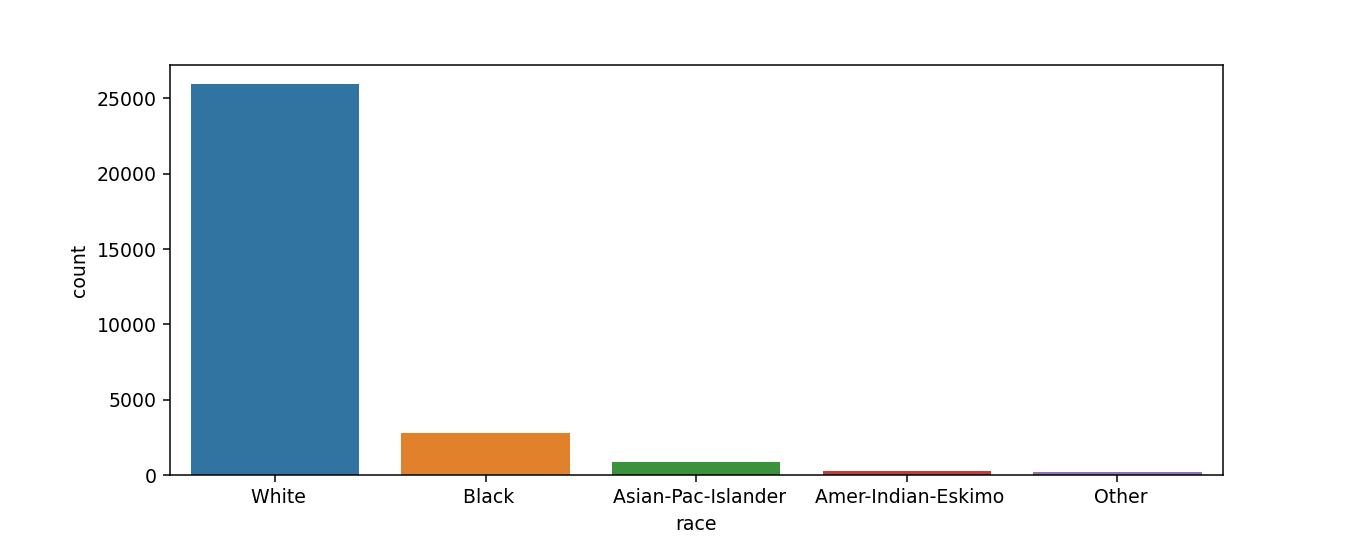

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
sns.countplot(data=X, x=X[cat_cols[5]], ax=ax) 
plt.show()

<IPython.core.display.Javascript object>


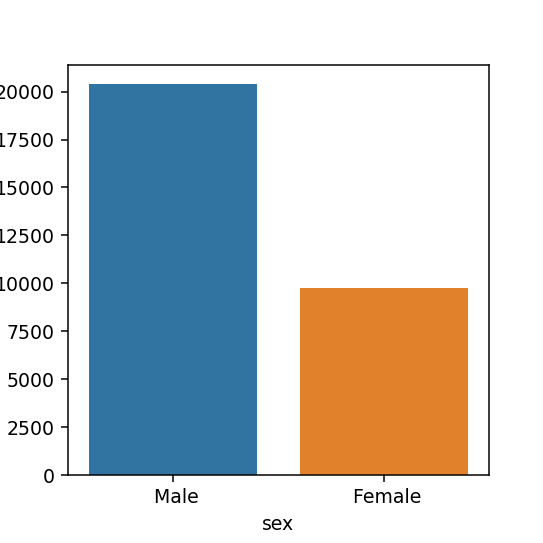

In [26]:
fig, ax = plt.subplots(figsize=(4,4))
sns.countplot(data=X, x=X[cat_cols[6]], ax=ax) 
plt.show()

<IPython.core.display.Javascript object>


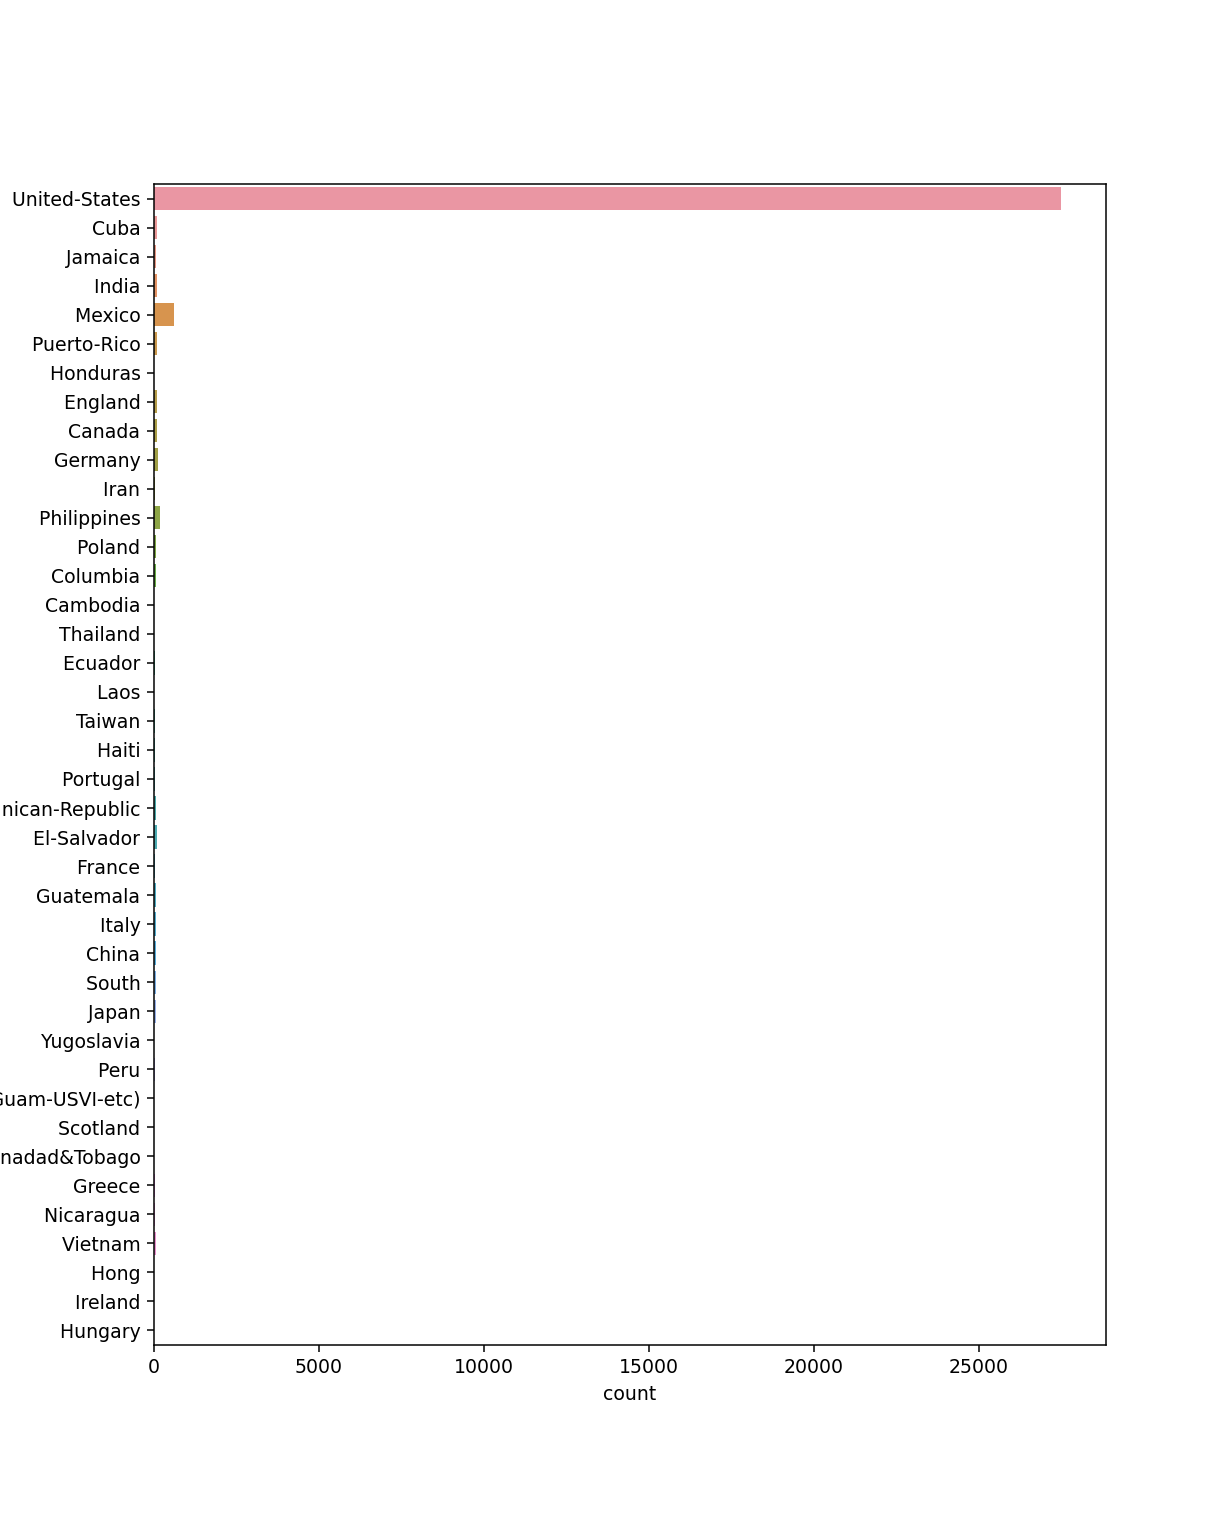

In [27]:
fig, ax = plt.subplots(figsize=(8,10))
sns.countplot(data=X, y=X[cat_cols[7]], ax=ax) 
plt.show()

#### 3.3.3 Target distribution 

<IPython.core.display.Javascript object>


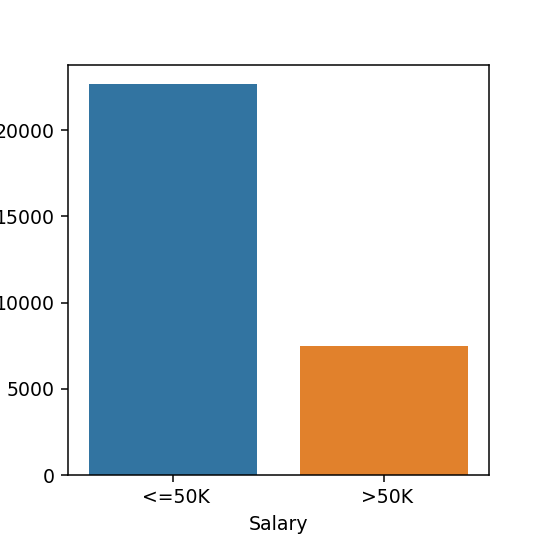

In [28]:
fig, ax = plt.subplots(figsize=(4,4))
sns.countplot(data=X, x=y, ax=ax) 
plt.show()

#### 3.3.4 Preprocessing and visualizing the classes

#### a) Frequency encode the 'native' column

In [98]:
count_map_native = X['native'].value_counts().to_dict() 

In [99]:
count_map_native

{' United-States': 27504,
 ' Mexico': 610,
 ' Philippines': 188,
 ' Germany': 128,
 ' Puerto-Rico': 109,
 ' Canada': 107,
 ' India': 100,
 ' El-Salvador': 100,
 ' Cuba': 92,
 ' England': 86,
 ' Jamaica': 80,
 ' South': 71,
 ' China': 68,
 ' Italy': 68,
 ' Dominican-Republic': 67,
 ' Vietnam': 64,
 ' Guatemala': 63,
 ' Japan': 59,
 ' Poland': 56,
 ' Columbia': 56,
 ' Iran': 42,
 ' Taiwan': 42,
 ' Haiti': 42,
 ' Portugal': 34,
 ' Nicaragua': 33,
 ' Peru': 30,
 ' Greece': 29,
 ' France': 27,
 ' Ecuador': 27,
 ' Ireland': 24,
 ' Hong': 19,
 ' Cambodia': 18,
 ' Trinadad&Tobago': 18,
 ' Laos': 17,
 ' Thailand': 17,
 ' Yugoslavia': 16,
 ' Outlying-US(Guam-USVI-etc)': 14,
 ' Hungary': 13,
 ' Honduras': 12,
 ' Scotland': 11}

In [100]:
X_fenc = pd.Series(X['native'].map(count_map_native), index=X.index, name='native')

In [101]:
X_fenc.unique()

array([27504,    92,    80,   100,   610,   109,    12,    86,   107,
         128,    42,   188,    56,    18,    17,    27,    34,    67,
          63,    68,    71,    59,    16,    30,    14,    11,    29,
          33,    64,    19,    24,    13], dtype=int64)

#### b) One hot encode the remaining categorical columns

In [120]:
enc = OneHotEncoder(sparse=False)

In [121]:
X_cat_enc = pd.DataFrame(enc.fit_transform(X[cat_cols_oe]),
                         index=X.index,
                         )#columns=X[cat_cols_oe].columns

In [122]:
X_prep = pd.concat([X[numeric_cols], X_cat_enc, X_fenc], axis=1)

In [123]:
X_prep.head()

,age,educationno,capitalgain,capitalloss,hoursperweek,0,1,2,3,4,...,48,49,50,51,52,53,54,55,56,native
0,39,13,2174,0,40,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,27504
1,50,13,0,0,13,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,27504
2,38,9,0,0,40,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,27504
3,53,7,0,0,40,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,27504
4,28,13,0,0,40,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,92


In [124]:
X_prep.shape

(30161, 63)

In [125]:
y.unique()

array([' <=50K', ' >50K'], dtype=object)

#### c) Converting target label to 0 and 1

In [126]:
y_prep = y.apply(lambda x:1 if(x==' >50K') else 0)

In [127]:
y_prep.unique()

array([0, 1], dtype=int64)

<IPython.core.display.Javascript object>


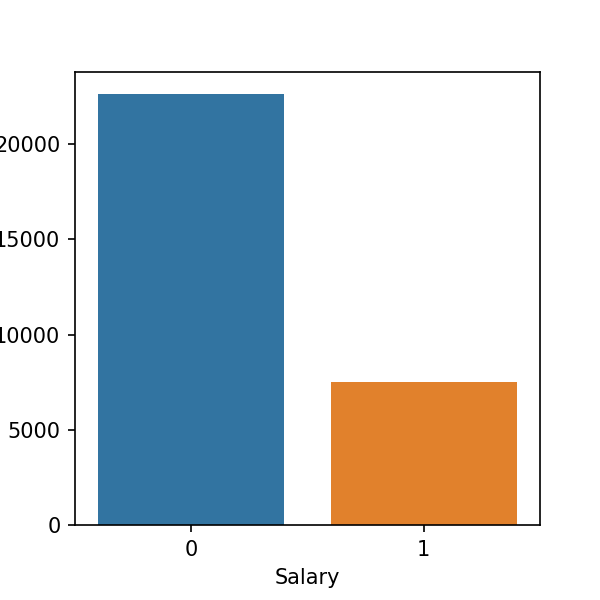

In [128]:
fig, ax = plt.subplots(figsize=(4,4))
sns.countplot(data=X, x=y_prep, ax=ax) 
plt.show()

#### d) Heatmap to find correlations

<IPython.core.display.Javascript object>


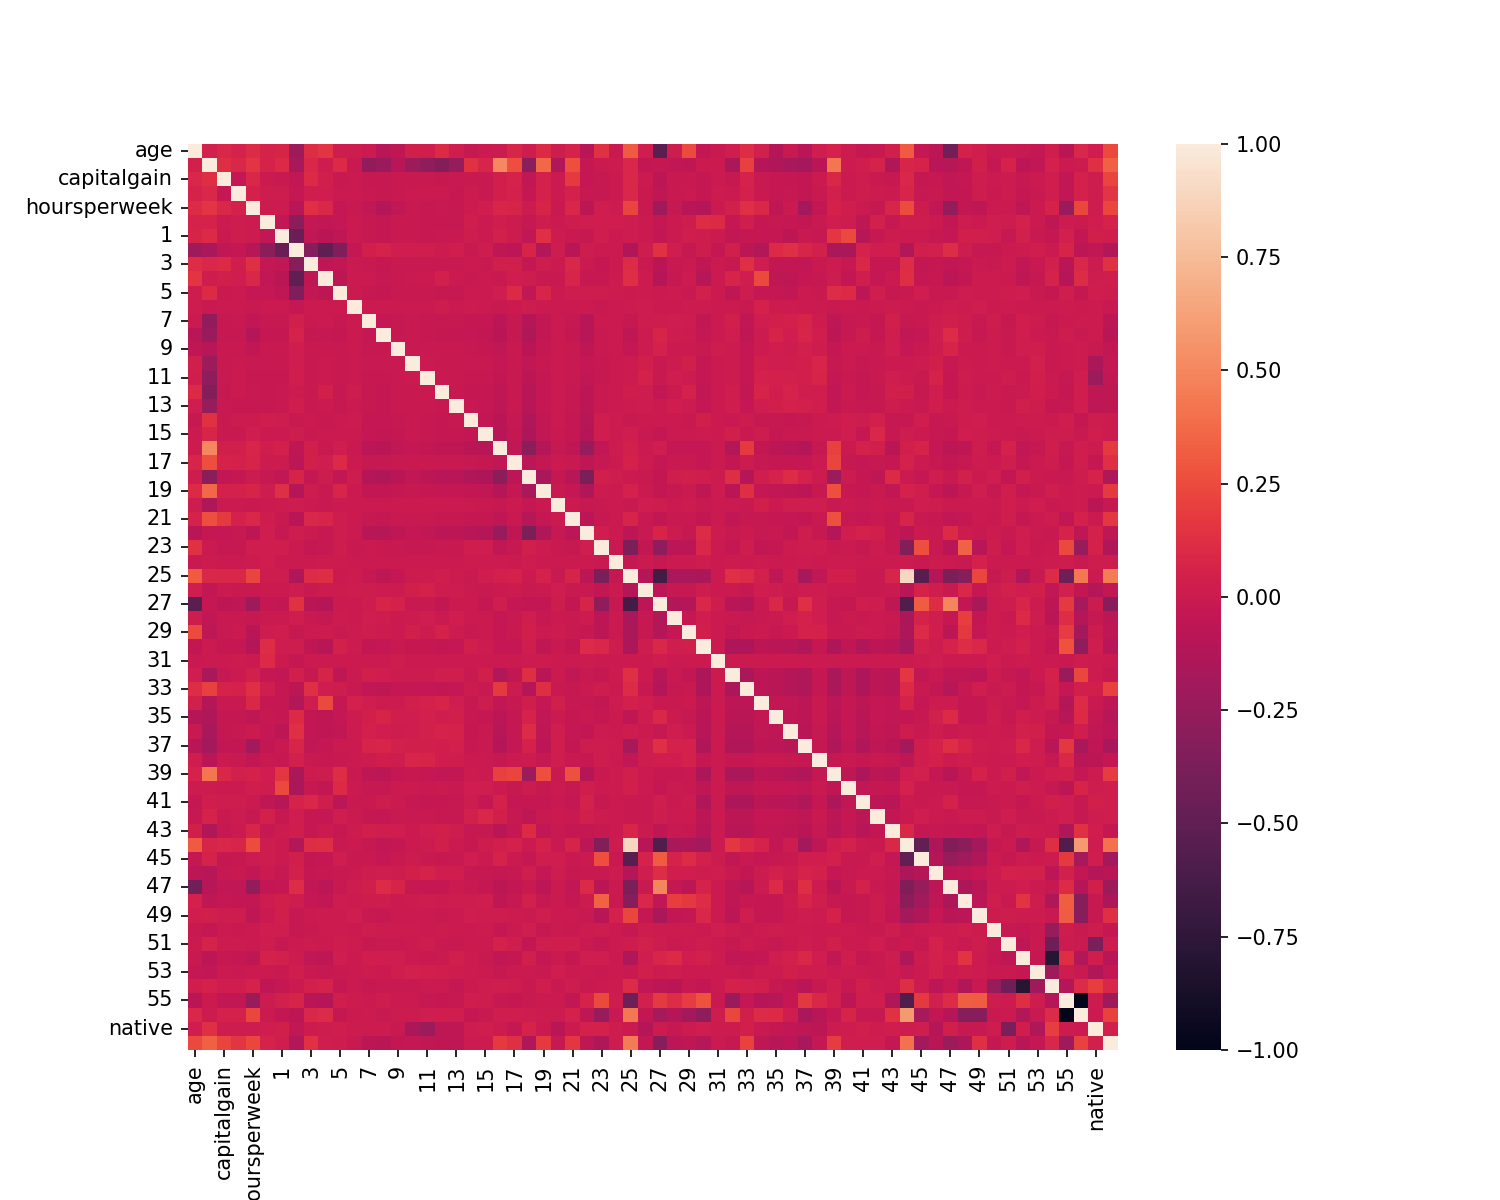

In [129]:
df_heatmap = pd.concat([X_prep, y_prep], axis=1)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_heatmap.corr(), ax=ax, annot=False)
plt.show()

#### e) Visualizing the output classes

In [130]:
def cluster_visualization(df_sc, labels):
    # PCA - N-D to 2D for scatterplot.
    pca = PCA(2)
    df_pca = pca.fit_transform(df_sc)
    u_labels = np.unique(labels)
    
    # Plotting
    fig, ax = plt.subplots()
    for i in u_labels:
        ax.scatter(df_pca[labels == i, 0], df_pca[labels == i, 1], label=i, alpha=0.5)
        
    ax.legend()    

In [131]:
scaler = StandardScaler()#MinMaxScaler()#
X_prep_sc = pd.DataFrame(scaler.fit_transform(X_prep), columns=X_prep.columns)

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


<IPython.core.display.Javascript object>


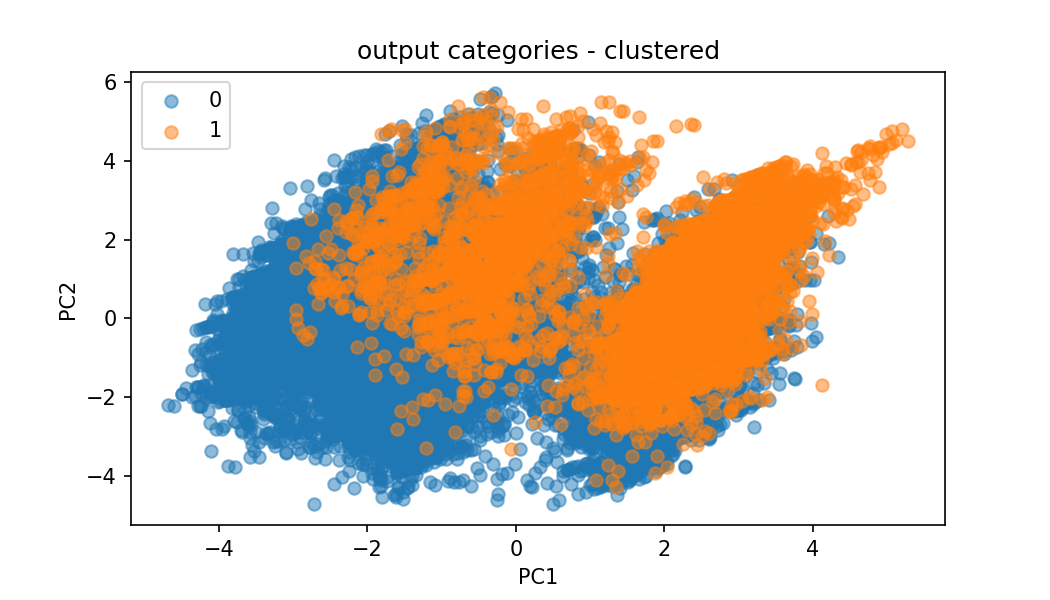

In [132]:
cluster_visualization(X_prep_sc, y_prep)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('output categories - clustered')
plt.show()

### 3.3.5 Observations:
- 13 features, 1 target. There is a mix of numerical and categorical features.
- No null values. All features recorded with correct datatypes.
- Target needs to be segregated into 0 and 1 class.
 - salary <=50K - 0 class.
 - salary >50K - 1 class.
- The feaures are not distributed normally. Most of the features are skewed.
- From the heatmap, we see that there are some correlations within features.
- From the scatter plot for visualizing the output, we see that there a strong overlap between the classes.

## 4. Model Building:

### 4.1 Baseline model with cross validation

#### 4.1.1 Making a custom frequency encoder to make the pipeline do the frequency encoding.

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin 

In [47]:
class frequency_encoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        # column -> column name to be transformed
        # col_map -> dict derived from the training set 
        self.column = column
        
    def fit(self, X, y=None):        
        self.map = X[self.column].value_counts().to_dict()
        return self
    
    def transform(self, X, y=None):
        Xtrf = X.copy() 
        Xtrf[self.column] = Xtrf[self.column].map(self.map) 
        return Xtrf
        

#### 4.1.2 Simple train test split for baseline model.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y_prep, test_size=0.2, random_state=42, stratify=y_prep)

In [49]:
#req_features = ['native'] + cat_cols_oe + numeric_cols

#### 4.1.3 Constructing the data preprocessing pipeline.

In [50]:
# Data preprocessing
categorical_transformer_1 = Pipeline(steps=[
    ('freq_enc', frequency_encoder(column='native')),
    ('scaler', StandardScaler())
])

categorical_transformer_2 = Pipeline(steps=[
    ('cat_enc', OneHotEncoder(sparse=False)),
    ('scaler', StandardScaler())
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [51]:
preprocessor = ColumnTransformer(transformers=[
    ('freq_trf', categorical_transformer_1, ['native']),
    ('cat_trf', categorical_transformer_2, cat_cols_oe),
    ('num_trf', numeric_transformer, numcols)    
], remainder='drop')#

#### 4.1.4 Constructing the baseline model

In [52]:
sv_clf = SVC()

In [53]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf)
])

In [54]:
%%time
clf.fit(X_train, y_train )

Wall time: 21.7 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('freq_trf',
                                                  Pipeline(steps=[('freq_enc',
                                                                   frequency_encoder(column='native')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['native']),
                                                 ('cat_trf',
                                                  Pipeline(steps=[('cat_enc',
                                                                   OneHotEncoder(sparse=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['workclass', 'education',
                

#### 4.1.5 Evaluating the baseline model

In [55]:
%%time
y_pred = clf.predict(X_test)

Wall time: 6.06 s


In [56]:
def display_results(y_test, y_pred, clf):
    """Displays model evaluation/performance report that includes
    accuracy_score, confusion_matrix, precision_score, and 
    recall_score.
    input
    -----
    y_test, y_pred
    
    output
    ------
    Model evaluation/performance report"""
    print(classification_report(y_test, y_pred))
    #print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=clf.classes_, ax=ax)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4531
           1       0.75      0.60      0.66      1502

    accuracy                           0.85      6033
   macro avg       0.81      0.77      0.78      6033
weighted avg       0.84      0.85      0.84      6033



<IPython.core.display.Javascript object>


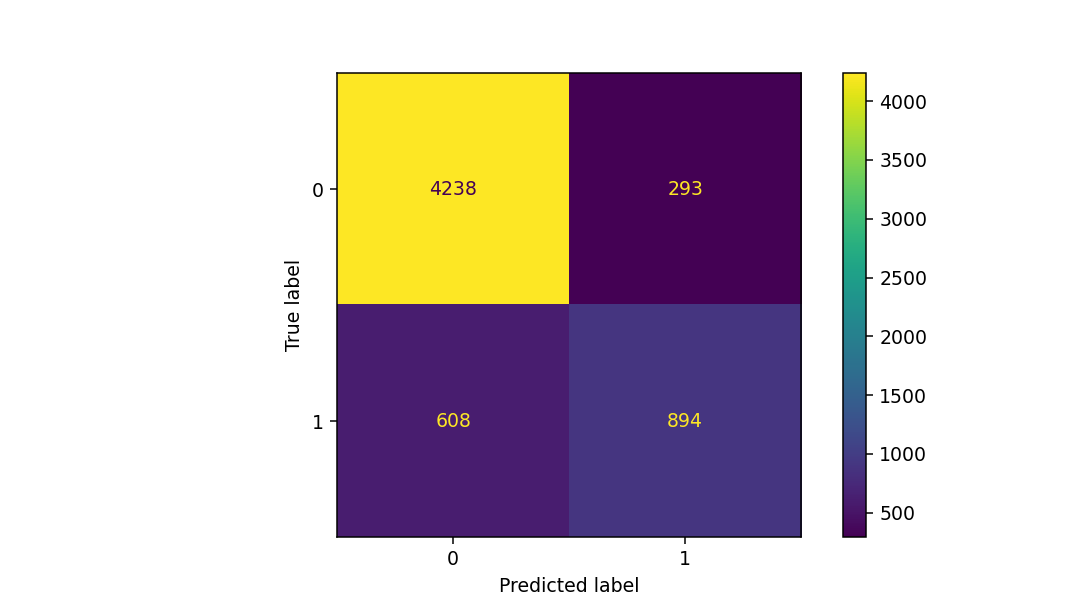

In [57]:
display_results(y_test, y_pred, clf)

#### 4.1.6 Kfold cross validation for the baseline model

In [80]:
# Custom kfold cross validation function.
def cross_validator(clf, Xdf, ydf, cv=5):
    # K fold cross validation:
    crv_scores_acc = cross_val_score(estimator=clf, X=Xdf, y=ydf, cv=cv, scoring='accuracy', n_jobs=-1)
    crv_scores_prec = cross_val_score(estimator=clf, X=Xdf, y=ydf, cv=cv, scoring='precision', n_jobs=-1)
    crv_scores_rec = cross_val_score(estimator=clf, X=Xdf, y=ydf, cv=cv, scoring='recall', n_jobs=-1)
    
    vals = [round(crv_scores_acc.mean(),4),
            round(crv_scores_prec.mean(),4),
            round(crv_scores_rec.mean(),4)
           ]
    return vals

In [81]:
# Function to display the cross validation scores.
def model_summary(vals):
    # Summarizing scores:
    print("mean accuracy            :{} ".format(vals[0]))
    print("mean precision(1 class)  :{} ".format(vals[1]))
    print("mean recall(1 class)     :{} ".format(vals[2]))

In [82]:
%%time
baseline_scores = cross_validator(clf=clf,
                                  Xdf=X,
                                  ydf=y_prep,
                                  cv=5)

Wall time: 3min 26s


In [83]:
scores = {}

In [84]:
scores['baseline'] = baseline_scores

In [85]:
model_summary(scores['baseline'])

mean accuracy            :0.8463 
mean precision(1 class)  :0.7401 
mean recall(1 class)     :0.5899 


### 4.2 Gridsearch for best params

In [86]:
clf_gs.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__freq_trf', 'preprocessor__cat_trf', 'preprocessor__num_trf', 'preprocessor__freq_trf__memory', 'preprocessor__freq_trf__steps', 'preprocessor__freq_trf__verbose', 'preprocessor__freq_trf__freq_enc', 'preprocessor__freq_trf__scaler', 'preprocessor__freq_trf__freq_enc__column', 'preprocessor__freq_trf__scaler__copy', 'preprocessor__freq_trf__scaler__with_mean', 'preprocessor__freq_trf__scaler__with_std', 'preprocessor__cat_trf__memory', 'preprocessor__cat_trf__steps', 'preprocessor__cat_trf__verbose', 'preprocessor__cat_trf__cat_enc', 'preprocessor__cat_trf__scaler', 'preprocessor__cat_trf__cat_enc__categories', 'preprocessor__cat_trf__cat_enc__drop', 'preprocessor__cat_trf__cat_enc__dty

In [58]:
sv_clf_gs = SVC(verbose=True)

clf_gs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf_gs)
])

In [59]:
parameters = {'classifier__kernel':['rbf'],
               'classifier__gamma':[0.01, 1, 5],
               'classifier__C':[0.5, 5, 15]
             }


In [60]:
grid_search = GridSearchCV(estimator=clf_gs,
                           param_grid=parameters,
                           scoring='accuracy',
                           n_jobs=4,
                           cv=5,
                           error_score='raise')

In [61]:
%%time
grid_search.fit(X, y_prep)

[LibSVM]Wall time: 48min 51s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('freq_trf',
                                                                         Pipeline(steps=[('freq_enc',
                                                                                          frequency_encoder(column='native')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['native']),
                                                                        ('cat_trf',
                                                                         Pipeline(steps=[('cat_enc',
                                                                                          OneHotEncoder(spar

In [62]:
grid_search.best_params_ 

{'classifier__C': 5, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}

In [63]:
grid_search.best_score_ 

0.8484468326503084

### 4.3 Building model using the results of gridsearch - Model 1

In [76]:
sv_clf_g1 = SVC(C=5,
    kernel='rbf',
    gamma=0.01)

clf_gs1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sv_clf_g1)
])

### 4.4 Fit Model 1 

In [77]:
clf_gs1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('freq_trf',
                                                  Pipeline(steps=[('freq_enc',
                                                                   frequency_encoder(column='native')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['native']),
                                                 ('cat_trf',
                                                  Pipeline(steps=[('cat_enc',
                                                                   OneHotEncoder(sparse=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['workclass', 'education',
                

#### 4.4.1 Evaluate Model 1

In [78]:
y_pred_gl = clf_gs1.predict(X_test)

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4531
           1       0.75      0.60      0.67      1502

    accuracy                           0.85      6033
   macro avg       0.81      0.77      0.78      6033
weighted avg       0.84      0.85      0.84      6033



<IPython.core.display.Javascript object>


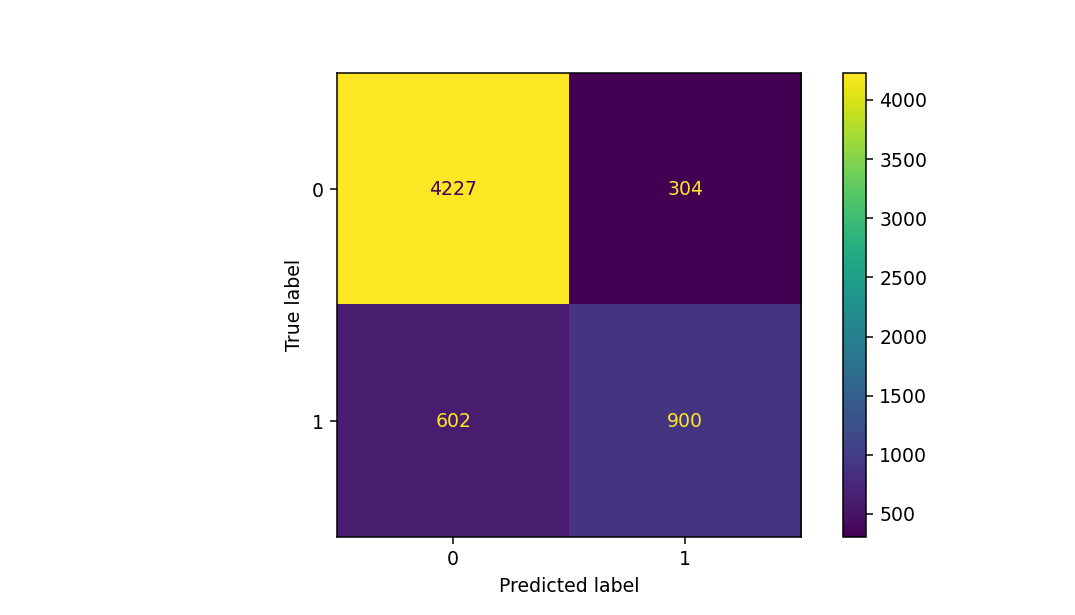

In [79]:
display_results(y_test, y_pred_gl, clf=clf_gs1)

#### 4.4.2 Model 1 evaluation - Kfold cross validation.

### 4.3 Observations:
- From the above analysis we see that SVM is performing somewhat poorly at classifying the high salary categoy (1 class); this despite using different data preprocessing techniques and gridsearch.
- Since the grid search process was slow, different kernels were tried out initially on the baseline model(not shown in the present notebook. The kernel: 'rbf, was found to perform better compared to the rest.
- 'Model 1'
- We will use 'Model 1' to test on the unseen data.


## 5. Testing on unseen data

### 5.1 Load data

In [87]:
salary_testdf = pd.read_csv('SalaryData_Test(1).csv')

In [89]:
salary_testdf.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [88]:
salary_testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            15060 non-null  int64 
 1   workclass      15060 non-null  object
 2   education      15060 non-null  object
 3   educationno    15060 non-null  int64 
 4   maritalstatus  15060 non-null  object
 5   occupation     15060 non-null  object
 6   relationship   15060 non-null  object
 7   race           15060 non-null  object
 8   sex            15060 non-null  object
 9   capitalgain    15060 non-null  int64 
 10  capitalloss    15060 non-null  int64 
 11  hoursperweek   15060 non-null  int64 
 12  native         15060 non-null  object
 13  Salary         15060 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.6+ MB


#### 5.1.1 Observations:
- No null values
- All columns present

In [90]:
X_1, y_1 = Xy_split(salary_testdf, y_name='Salary')

In [91]:
X_1.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States


In [95]:
y_1.head()

0     <=50K
1     <=50K
2      >50K
3      >50K
4     <=50K
Name: Salary, dtype: object

In [96]:
y_1_prep = y_1.apply(lambda x:1 if(x==' >50K') else 0)

In [93]:
y_pred_1 = clf_gs1.predict(X_1)

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11360
           1       0.73      0.60      0.66      3700

    accuracy                           0.85     15060
   macro avg       0.80      0.76      0.78     15060
weighted avg       0.84      0.85      0.84     15060



<IPython.core.display.Javascript object>


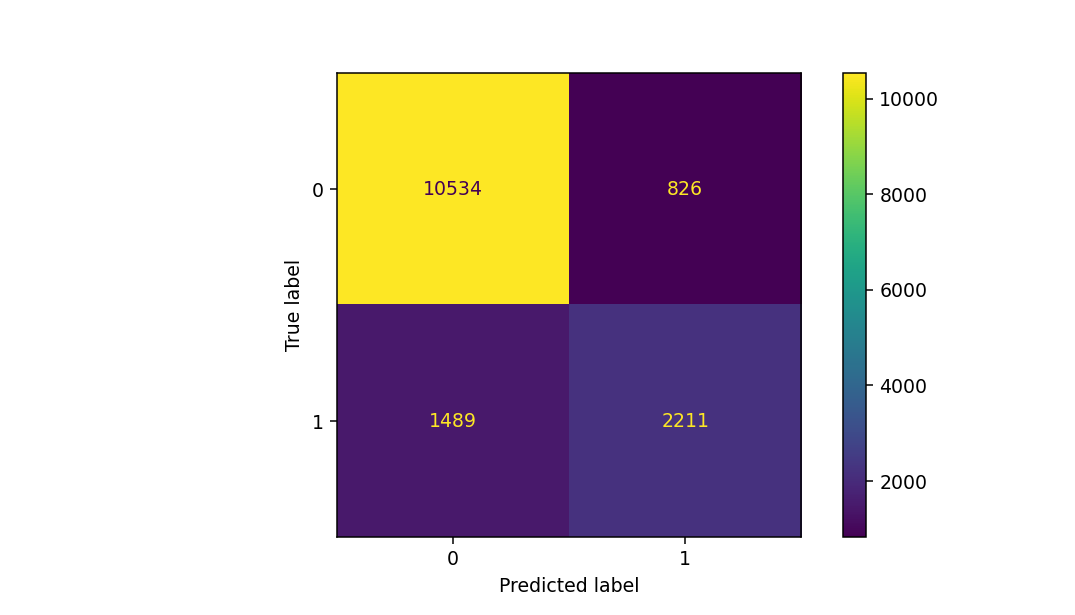

In [97]:
display_results(y_1_prep, y_pred_1, clf=clf_gs1)

## 5.2 Observations:
- The preformance on the unseen dataset is similat to the model's performance on the test set used during model building.
- This model may not be effective in predicting individuals with high salaries since there is a large portion of misclassified data points fot the high salary class (1 class).

## 6. Conclusion
An attempt was made to predict the salary levels of individuals based on their persomal data using SVM. It wa found that the SVM model developed was performing somewhat poorly when classifying individuals with high salaries.